Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.

# Generate Synthetic Data with CasTGAN

* <b>NOTES</b>
  * Can't be installed through `pip`, see execution details in "Generate Synthetic Data with CasTGAN" section
  * Generated synthetic numerical data can have invalid value range, such as `pdays` in this case
  * Can't recognize pandas 'object' data type, has to be 'str' type

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from lightgbm import LGBMClassifier

from utils import *

import warnings
warnings.filterwarnings('ignore')

## Generate Data Input

In [2]:
raw_df = pd.read_pickle('../../crystal_ball/data_collector/structured_data/campaign_deposit.pkl')
print(raw_df.shape)

raw_df.head()

(11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [3]:
target = 'deposit'
num_cols = [col for col in raw_df.columns if raw_df[col].dtype != 'O' and col != target]
cat_cols = [col for col in raw_df.columns if raw_df[col].dtype == 'O' and col != target]

print(len(num_cols), len(cat_cols))
print(num_cols)
print(cat_cols)

7 9
['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [4]:
X_train, X_test, y_train, y_test = train_test_split(raw_df.drop(target, axis=1), raw_df[target], 
                                                    test_size=0.25, random_state=10,
                                                    stratify=raw_df[target])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(len(X_train)/len(raw_df))
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_test.head()

(8371, 16) (2791, 16) (8371,) (2791,)
0.7499552051603655
0    0.526102
1    0.473898
Name: deposit, dtype: float64
0    0.526335
1    0.473665
Name: deposit, dtype: float64


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,33,admin.,married,secondary,no,7,yes,no,cellular,17,apr,612,1,148,1,failure
1,59,retired,married,tertiary,no,422,yes,no,cellular,14,may,647,4,-1,0,unknown
2,25,student,single,unknown,no,3,no,no,cellular,26,may,170,1,-1,0,unknown
3,51,blue-collar,married,primary,no,4497,yes,no,unknown,15,may,276,3,-1,0,unknown
4,49,admin.,single,secondary,no,293,no,no,cellular,28,jun,452,1,-1,0,unknown


In [8]:
# generate the data input required by CasTGAN
X_train.to_csv('CasTGAN/Data/campaign_train.csv', index=False)
X_test.to_csv('CasTGAN/Test_Data/campaign_test.csv', index=False)

raw_dtypes = X_train.dtypes.to_dict()
converted_dtypes = {}

for feature, dtype in raw_dtypes.items():
    str_dtype = str(dtype)
    if str_dtype == 'object':
        converted_dtypes[feature] = 'str'
    else:
        converted_dtypes[feature] = str_dtype
    
with open('CasTGAN/Data/campaign_dtypes.pkl', 'wb') as dp:
    pickle.dump(converted_dtypes, dp)

pd.read_pickle('CasTGAN/Data/campaign_dtypes.pkl')

{'age': 'int64',
 'job': 'str',
 'marital': 'str',
 'education': 'str',
 'default': 'str',
 'balance': 'int64',
 'housing': 'str',
 'loan': 'str',
 'contact': 'str',
 'day': 'int64',
 'month': 'str',
 'duration': 'int64',
 'campaign': 'int64',
 'pdays': 'int64',
 'previous': 'int64',
 'poutcome': 'str'}

## Generate Synthetic Data with CasTGAN

* To get CasTGAN ready
  * Git clone [CasTGAN][1]
  * Install required libraries by following the steps [here][1]
  
* To generate synthetic data with CasTGAN
  * Open your terminal
  * `cd` to cloned `CasTGAN` folder
  * Save your real train test data in CasTGAN folders, same as above code, change file names as needed
  * Run `python -m main --dataset="campaign" --epochs=10`, for more params choices, refer to [CasTGAN's code][2]
  
  
[1]:https://github.com/abedshantti/castgan
[2]:https://github.com/abedshantti/CasTGAN/blob/main/Model/CasTGAN.py#L380-L413

## Evaluate Generated Synthetic Data

* Compare distributions of real data and synthetic data
* Compare model efficacy using real data and synthetic data
* Also compare different synthetic data performance
  * Synthetic data generated with 10 epochs
  * Synthetic data generated with 50 epochs
* NOTE: In this case, we don't have data validity concerns in generated synthetic data

### Compare Distributions

* syn_X_train_10 was generated through `python -m main --dataset="campaign" --epochs=10`
* syn_X_train_50 was generated through `python -m main --dataset="campaign" --epochs=50 --discriminator_steps=2`
* It took 15 ~ 30 mins to generate each synthetic data above

In [5]:
syn_X_train_10 = pd.read_csv('CasTGAN/Generated_Data/wb_0/campaign_fake_20230901-2310.csv')
print(syn_X_train_10.shape)
display(syn_X_train_10)

(8371, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,17,management,married,secondary,no,2005,no,no,unknown,25,jul,258,3,-6,0,unknown
1,28,management,married,secondary,no,848,yes,no,telephone,18,may,288,2,140,1,unknown
2,24,management,married,secondary,no,2680,yes,no,unknown,34,aug,261,1,-5,0,unknown
3,43,management,married,secondary,no,2722,yes,no,unknown,10,aug,283,0,-4,0,unknown
4,17,management,married,secondary,no,2588,yes,no,unknown,27,jul,277,0,-6,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8366,18,entrepreneur,married,secondary,no,2699,yes,no,unknown,10,feb,279,1,-5,0,unknown
8367,17,technician,married,secondary,no,9065,yes,no,unknown,21,jul,272,3,-6,0,unknown
8368,35,technician,single,unknown,no,5800,yes,no,cellular,18,jul,636,2,158,0,unknown
8369,28,management,married,secondary,no,709,yes,no,unknown,34,jul,364,1,63,1,unknown


In [6]:
syn_X_train_50 = pd.read_csv('CasTGAN/Generated_Data/wb_0/campaign_fake_20230904-1929.csv')
print(syn_X_train_50.shape)
display(syn_X_train_50)

(8371, 16)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,62,admin.,married,secondary,no,2659,no,no,unknown,23,sep,407,2,-4,0,unknown
1,42,technician,single,secondary,no,163,no,no,cellular,14,feb,956,3,-3,0,unknown
2,37,unemployed,single,secondary,no,392,no,yes,unknown,9,jul,345,0,0,0,unknown
3,52,blue-collar,married,primary,no,1039,yes,no,unknown,1,may,476,1,-2,0,unknown
4,23,management,single,tertiary,no,96,yes,no,unknown,7,may,363,2,-2,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8366,62,management,married,tertiary,no,-13,yes,no,cellular,25,may,571,0,-1,0,unknown
8367,41,admin.,married,secondary,no,849,no,no,unknown,24,jun,218,0,-2,0,unknown
8368,32,management,single,tertiary,no,340,yes,yes,unknown,16,jun,239,1,-2,0,unknown
8369,62,services,divorced,secondary,no,291,no,no,unknown,14,feb,473,0,-3,0,unknown


In [7]:
# check data validatity
print(min(syn_X_train_10['pdays']), min(syn_X_train_50['pdays']))

-6 -5


In [8]:
real_num_df = X_train[num_cols]
real_num_df['data_mark'] = 'real'
real_cat_df = X_train[cat_cols]
real_cat_df['data_mark'] = 'real'

syn10_num_df = syn_X_train_10[num_cols]
syn10_num_df['data_mark'] = 'synthetic_10'
syn10_cat_df = syn_X_train_10[cat_cols]
syn10_cat_df['data_mark'] = 'synthetic_10'

syn50_num_df = syn_X_train_50[num_cols]
syn50_num_df['data_mark'] = 'synthetic_50'
syn50_cat_df = syn_X_train_50[cat_cols]
syn50_cat_df['data_mark'] = 'synthetic_50'

In [9]:
compare_num_df1 = pd.concat([real_num_df, syn10_num_df], ignore_index=True)
compare_cat_df1 = pd.concat([real_cat_df, syn10_cat_df], ignore_index=True)
compare_num_df1['balance'] = compare_num_df1['balance'].astype('float')
compare_num_df1['logged_balance'] = np.log(abs(compare_num_df1['balance']) + 1)\
                                             * np.sign(compare_num_df1['balance'])

compare_num_df2 = pd.concat([real_num_df, syn50_num_df], ignore_index=True)
compare_cat_df2 = pd.concat([real_cat_df, syn50_cat_df], ignore_index=True)
compare_num_df2['balance'] = compare_num_df2['balance'].astype('float')
compare_num_df2['logged_balance'] = np.log(abs(compare_num_df2['balance']) + 1)\
                                             * np.sign(compare_num_df2['balance'])

print(compare_num_df1.shape, compare_cat_df1.shape)
print(compare_num_df2.shape, compare_cat_df2.shape)

(16742, 9) (16742, 10)
(16742, 9) (16742, 10)


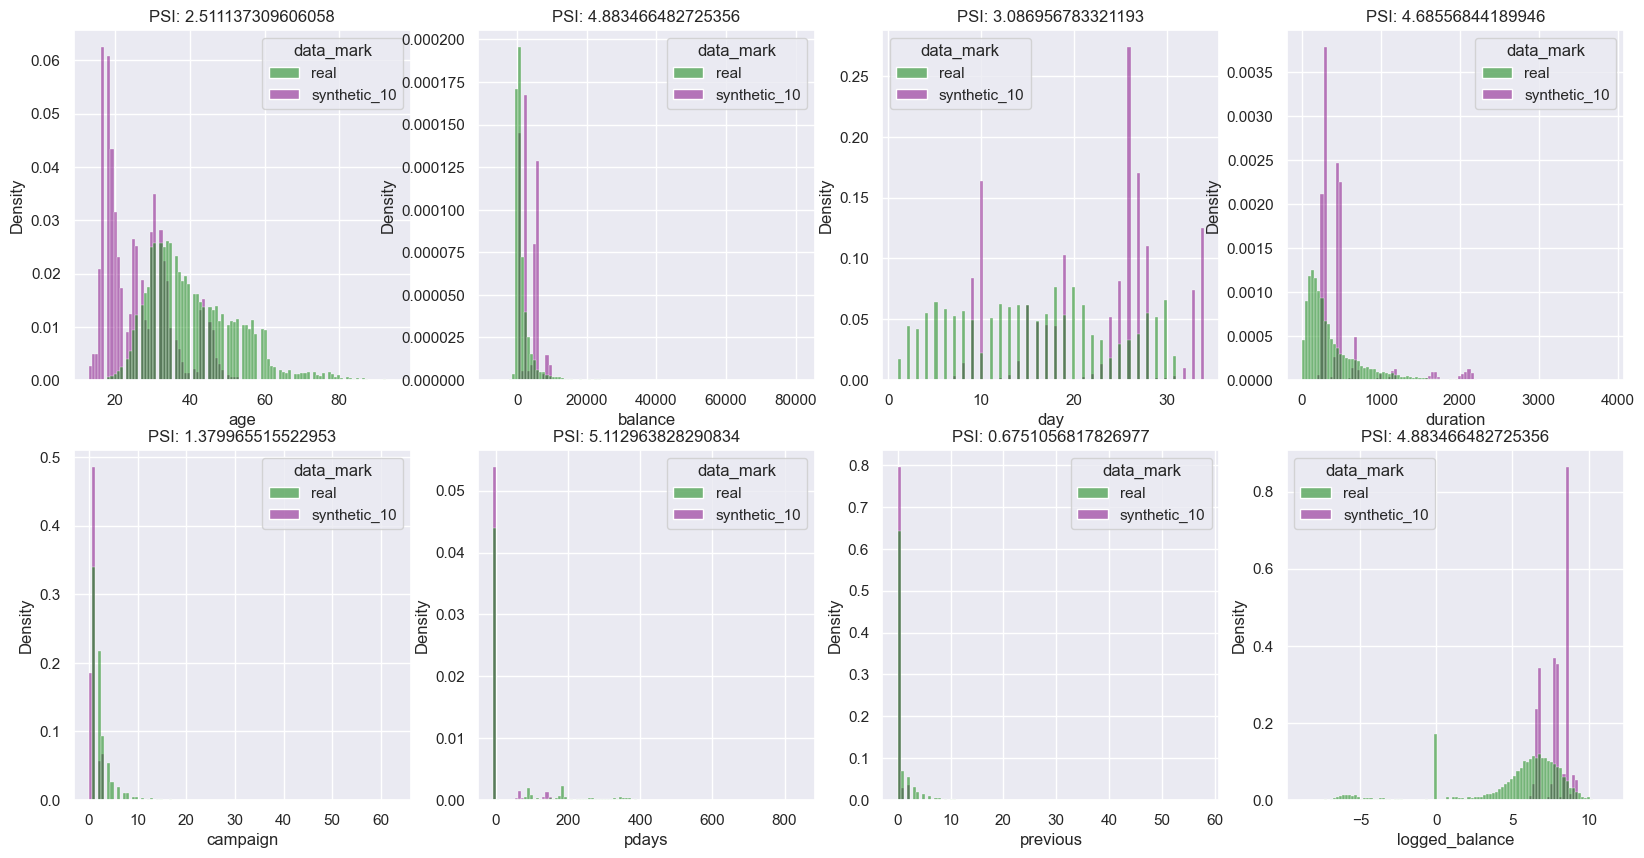

In [12]:
plot_num_feature_distribution_per_group(compare_num_df1, group_col='data_mark',
                                        n_rows=2, n_cols=4, exclude_cols=['data_mark'], 
                                        figsize=[20, 10], font_scale=1,
                                        group_values=['real', 'synthetic_10'],
                                        bins=100, palette=['green', 'purple'],
                                        distribution_metrics='psi', enable_dist_comp=True)

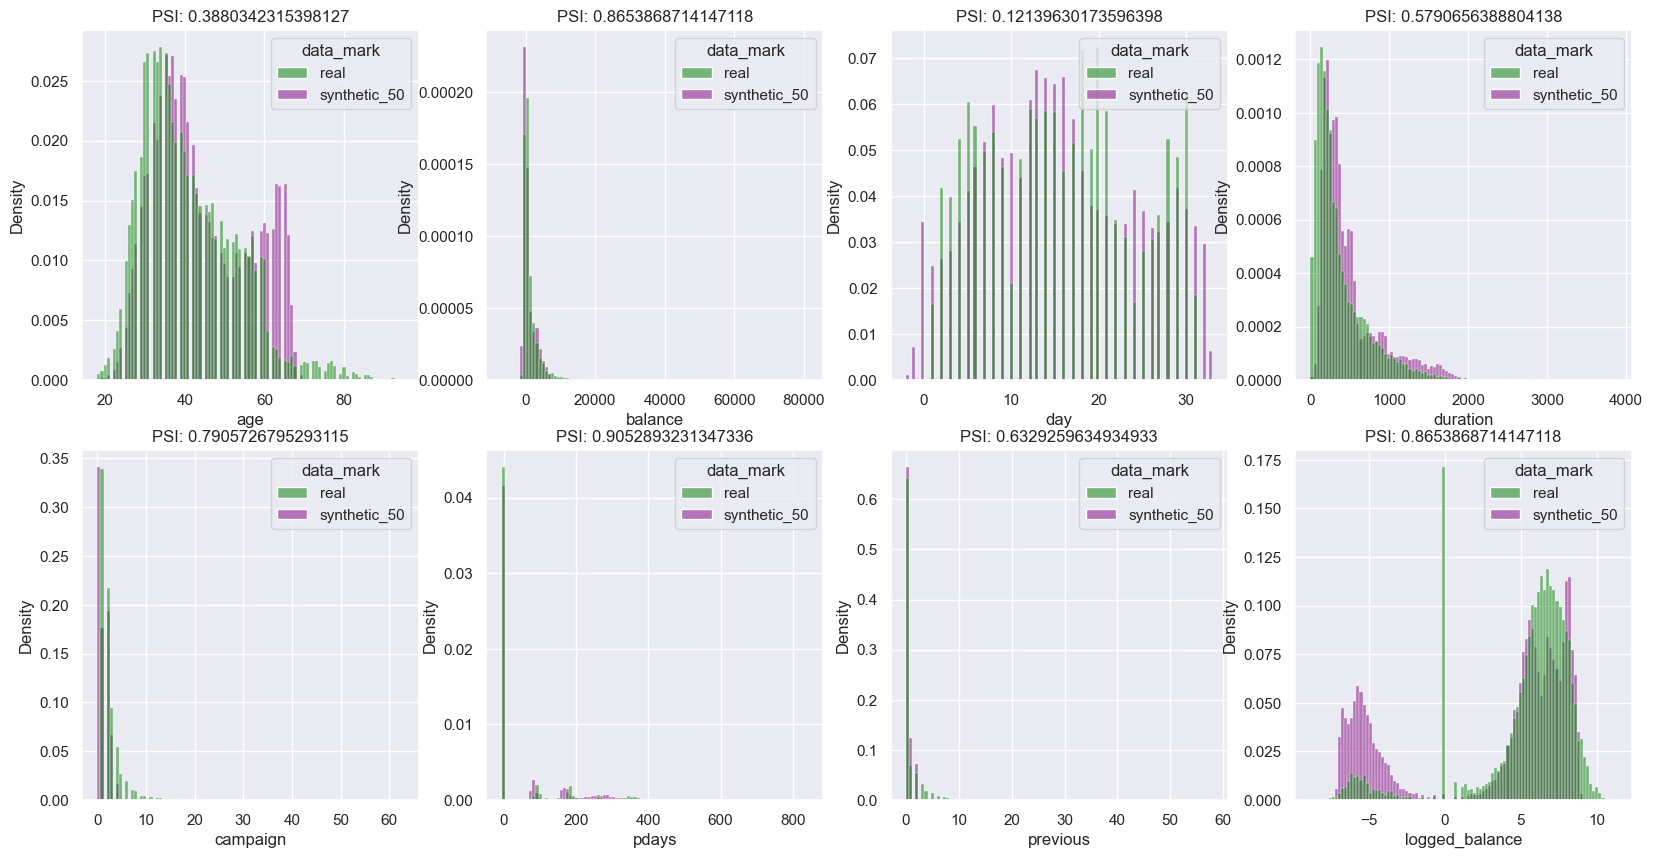

In [13]:
plot_num_feature_distribution_per_group(compare_num_df2, group_col='data_mark',
                                        n_rows=2, n_cols=4, exclude_cols=['data_mark'], 
                                        figsize=[20, 10], font_scale=1,
                                        group_values=['real', 'synthetic_50'],
                                        bins=100, palette=['green', 'purple'],
                                        distribution_metrics='psi', enable_dist_comp=True)

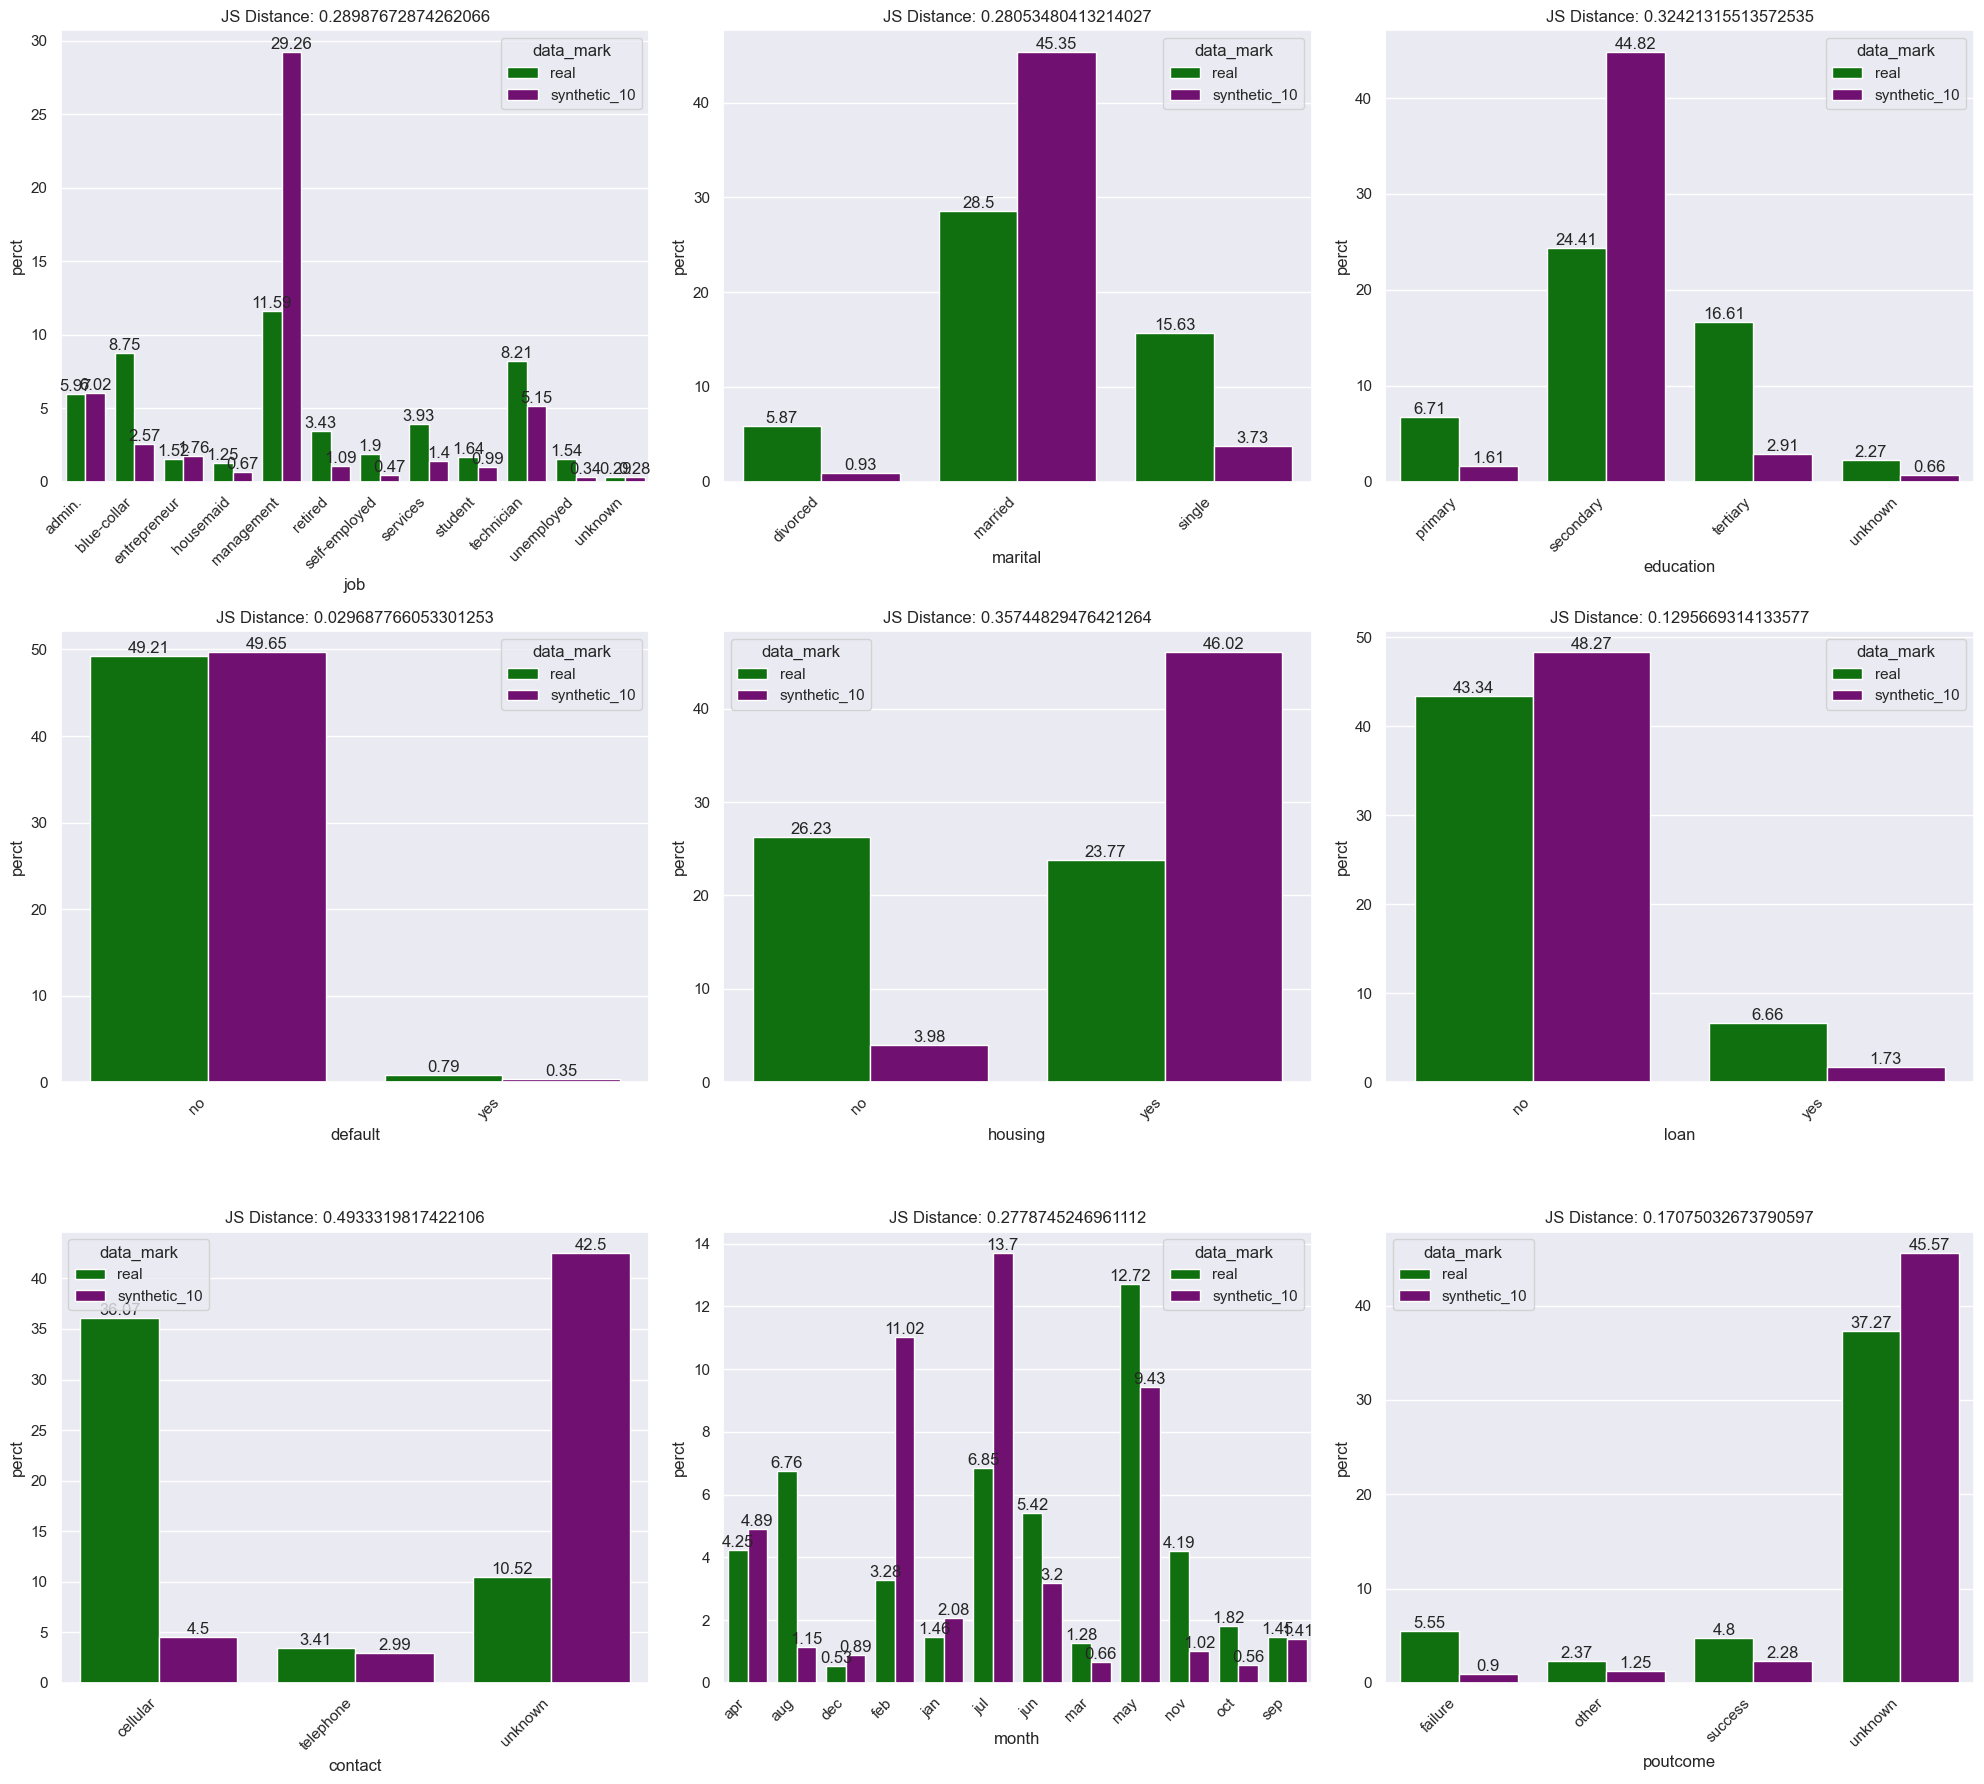

In [23]:
plot_cat_feature_distribution_per_group(compare_cat_df1, group_col='data_mark', 
                                        n_rows=3, n_cols=3, exclude_cols=['data_mark'], 
                                        figsize=[20, 18], font_size=12, palette=['green', 'purple'],
                                        group_values=['real', 'synthetic_10'], enable_dist_comp=True)

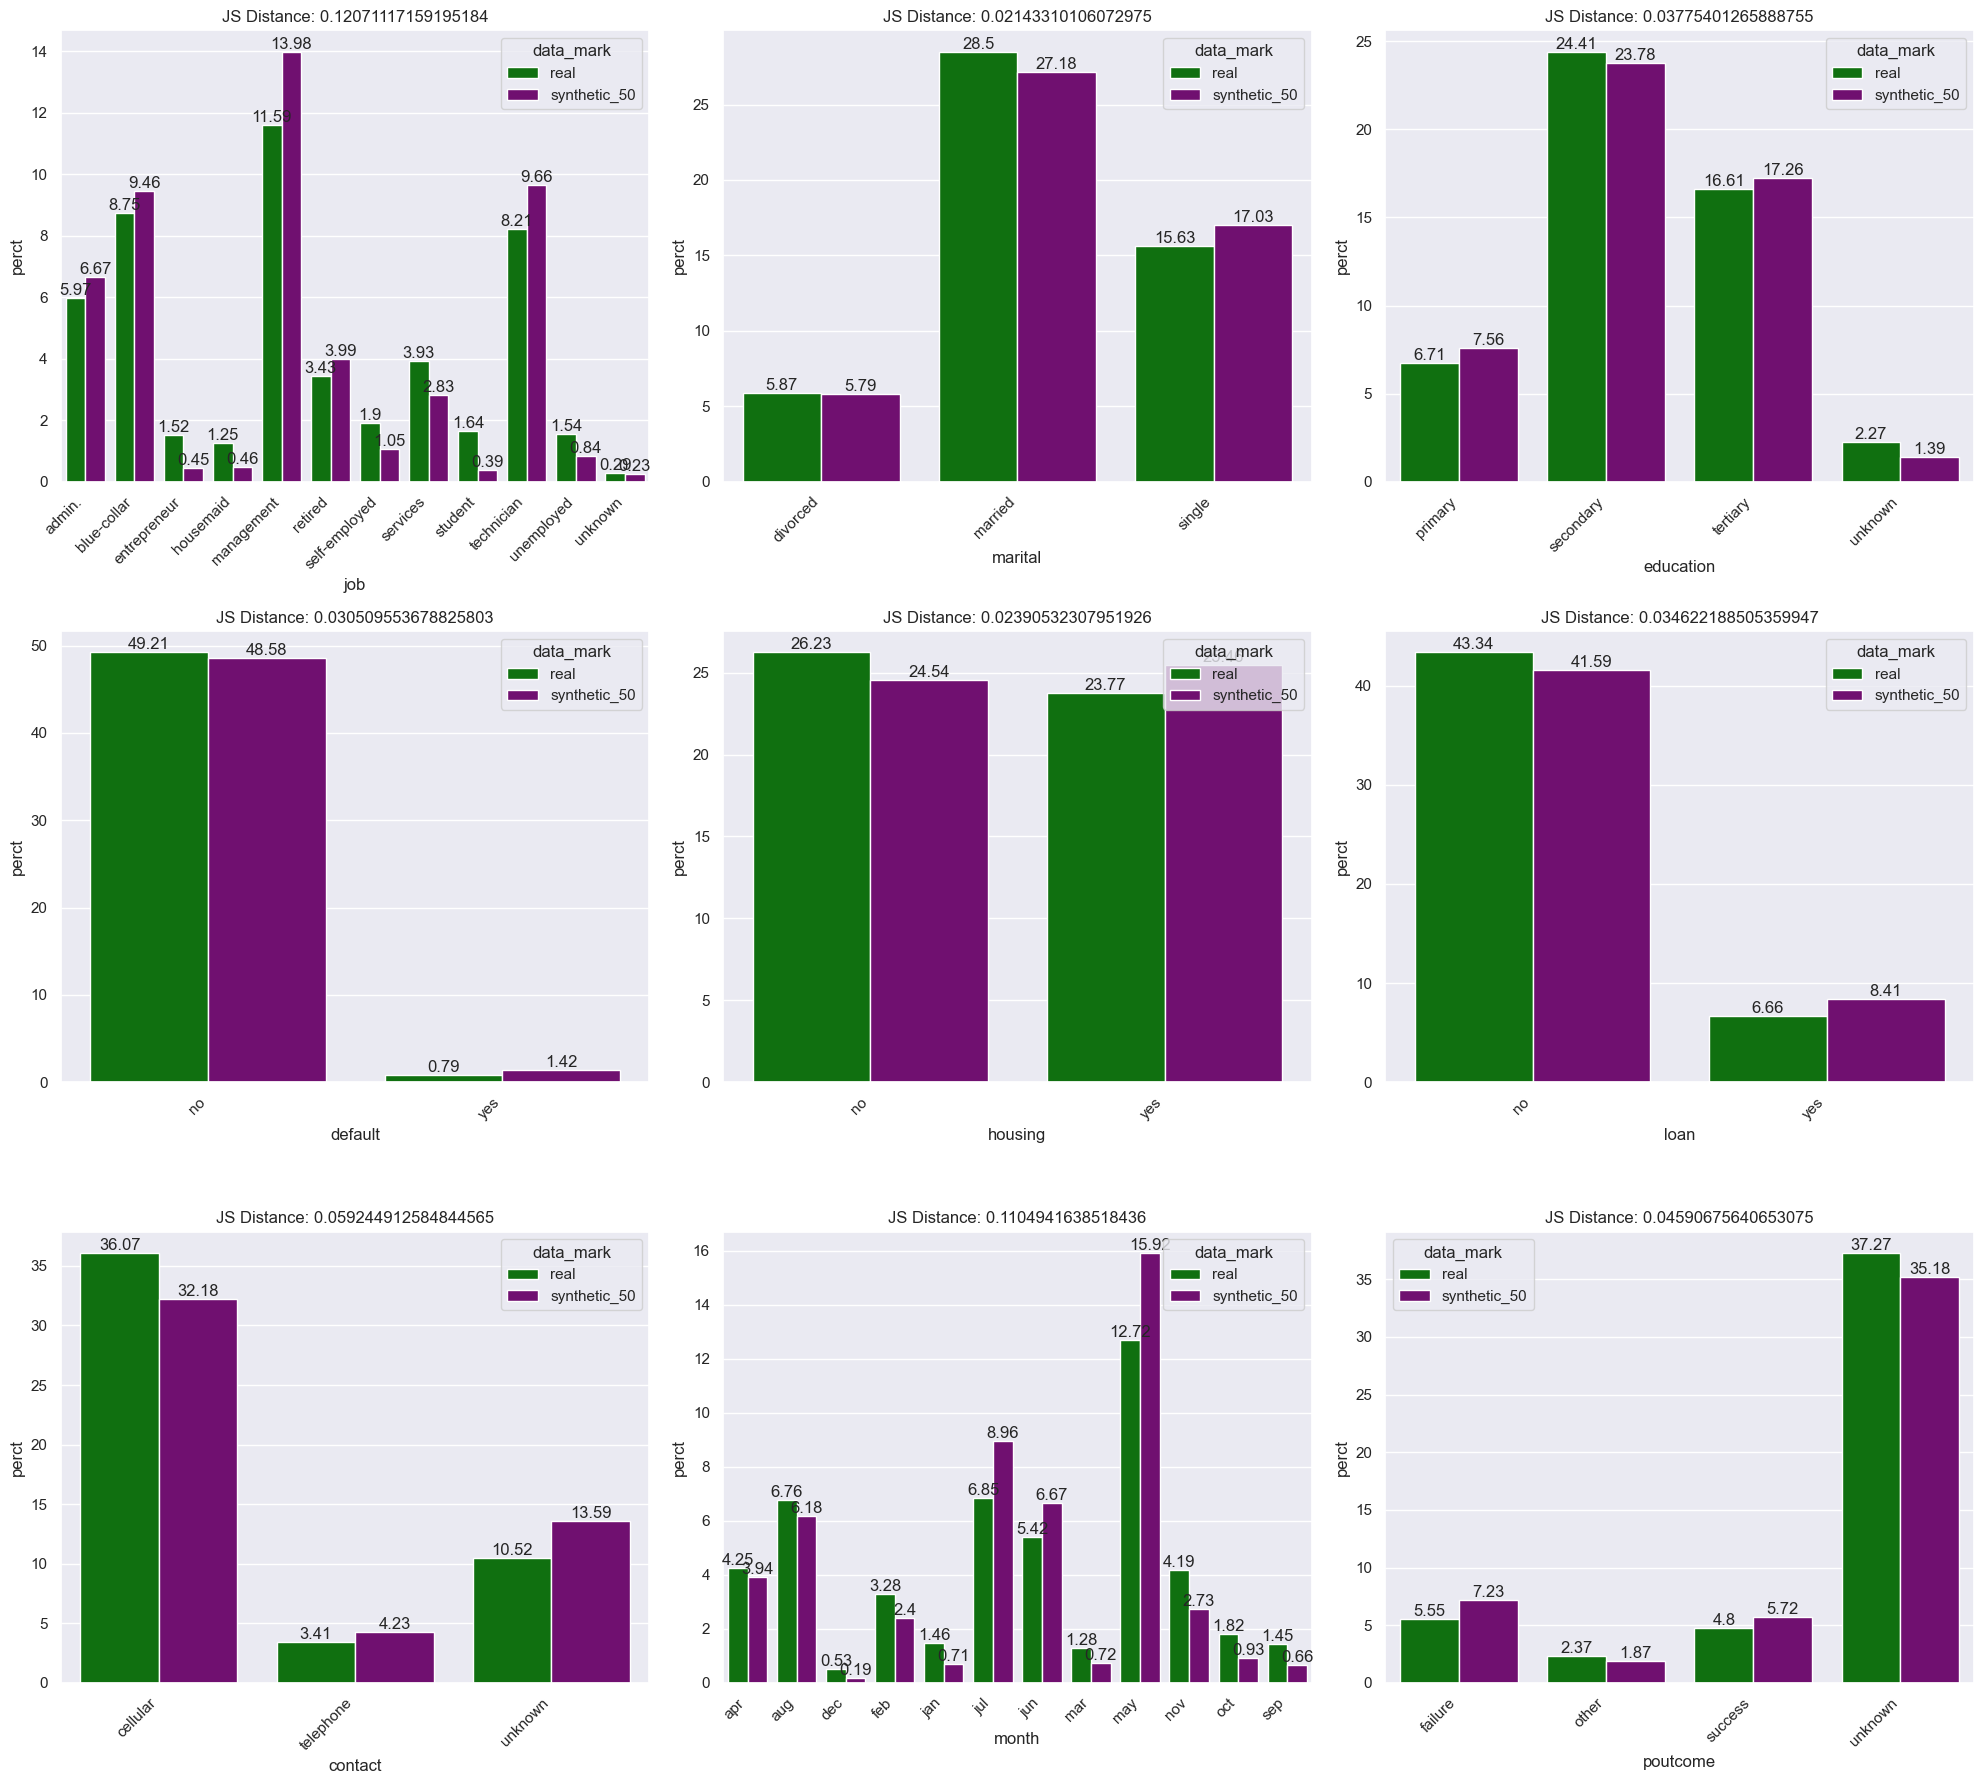

In [15]:
plot_cat_feature_distribution_per_group(compare_cat_df2, group_col='data_mark', 
                                        n_rows=3, n_cols=3, exclude_cols=['data_mark'], 
                                        figsize=[20, 18], font_size=12, palette=['green', 'purple'],
                                        group_values=['real', 'synthetic_50'], enable_dist_comp=True)

### Compare Model Efficacy

In [10]:
model_params = {'num_leaves': 4, 'learning_rate': 0.17937097905882862,
                'bagging_fraction': 0.8506740422636537,
                'feature_fraction': 0.6643670461510903,
                'bagging_freq': 18, 'min_data_in_leaf': 1133,
                'num_iterations': 2956, 'objective': 'binary',
                'metric': 'auc', 'random_state': 10,
                'verbosity': -1, 'boosting': 'gbdt',
                'num_threads': 4}

X_train[cat_cols] = X_train[cat_cols].astype('category')
X_test[cat_cols] = X_test[cat_cols].astype('category')

syn_X_train_10[cat_cols] = syn_X_train_10[cat_cols].astype('category')
syn_X_train_50[cat_cols] = syn_X_train_50[cat_cols].astype('category')

In [11]:
model_real = LGBMClassifier(**model_params)
model_real.fit(X_train, y_train)
y_pred1 = model_real.predict(X_test)
auc = roc_auc_score(y_test, y_pred1)
avp = average_precision_score(y_test, y_pred1)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Testing AUC is 0.8428958948887189, Testing Average Precision is 0.7699960261639714


In [12]:
model_syn10 = LGBMClassifier(**model_params)
model_syn10.fit(syn_X_train_10, y_train)
y_pred2 = model_syn10.predict(X_test)
auc = roc_auc_score(y_test, y_pred2)
avp = average_precision_score(y_test, y_pred2)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Testing AUC is 0.5735680616760505, Testing Average Precision is 0.5239236340711125


In [13]:
model_syn50 = LGBMClassifier(**model_params)
model_syn50.fit(syn_X_train_50, y_train)
y_pred3 = model_syn50.predict(X_test)
auc = roc_auc_score(y_test, y_pred3)
avp = average_precision_score(y_test, y_pred3)
print(f'Testing AUC is {auc}, Testing Average Precision is {avp}')

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.6643670461510903, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6643670461510903
[LightGBM] [Warning] min_data_in_leaf is set=1133, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1133
[LightGBM] [Warning] bagging_fraction is set=0.8506740422636537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8506740422636537
[LightGBM] [Warning] num_threads is set=4, n_jobs=-1 will be ignored. Current value: num_threads=4
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Testing AUC is 0.5036492967624399, Testing Average Precision is 0.4754991797311964


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

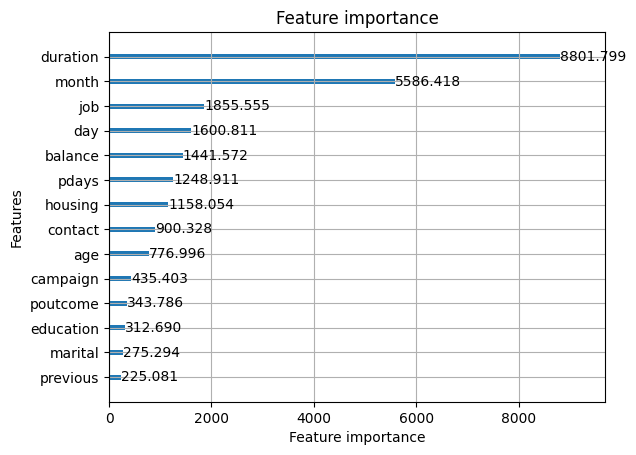

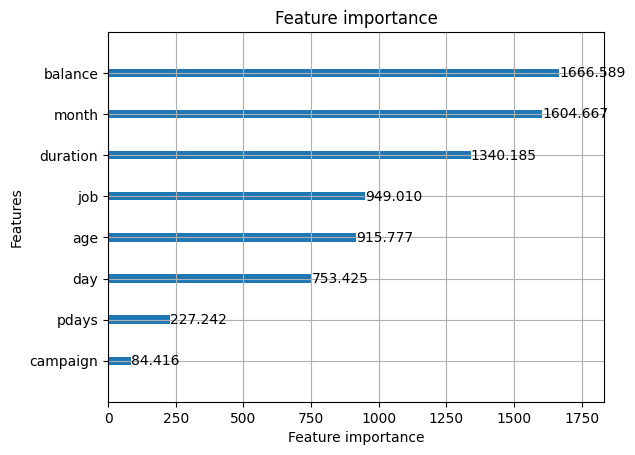

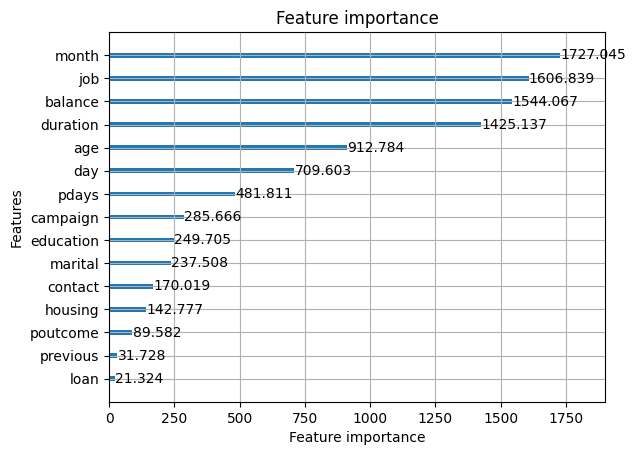

In [14]:
display(lgb.plot_importance(model_real, importance_type='gain'))

display(lgb.plot_importance(model_syn10, importance_type='gain'))

display(lgb.plot_importance(model_syn50, importance_type='gain'))